## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

In [1]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt', 'input.txt')
print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [8]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [11]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [12]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [13]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


Embedding weights:
Parameter containing:
tensor([[-0.4117, -0.8850,  1.7100, -1.6693],
        [-0.0715,  0.7712,  0.7904,  0.4028],
        [ 0.7204,  1.6774,  0.3279,  0.7761],
        [-0.6662,  0.6207,  0.4785, -0.6971]], requires_grad=True)


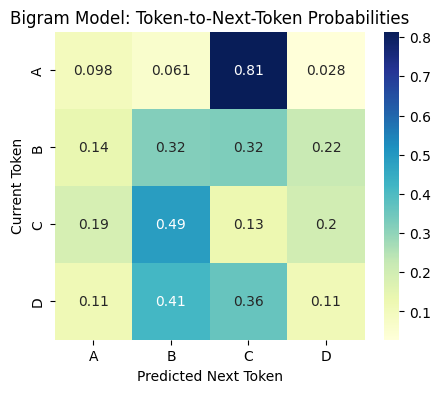

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Toy example
vocab = ['A', 'B', 'C', 'D']
vocab_size = len(vocab)
embedding = torch.nn.Embedding(vocab_size, vocab_size)

print("Embedding weights:")
print(embedding.weight)

# Get logits (one per token)
logits = embedding(torch.arange(vocab_size))  # shape: (4,4)
probs = F.softmax(logits, dim=1)  # convert to probabilities

# Plot as a heatmap
plt.figure(figsize=(5,4))
sns.heatmap(probs.detach().numpy(), annot=True, cmap="YlGnBu",
            xticklabels=vocab, yticklabels=vocab)
plt.xlabel("Predicted Next Token")
plt.ylabel("Current Token")
plt.title("Bigram Model: Token-to-Next-Token Probabilities")
plt.show()

Embedding Weights
Parameter containing:
tensor([[-1.1801, -0.5947,  0.3655],
        [-0.5123, -0.9898, -0.9791],
        [-0.1870,  1.5279, -0.0342],
        [-0.4404, -1.2271, -1.9693],
        [-0.6216,  0.2238, -0.4714],
        [-0.1522,  0.0787, -1.1028],
        [ 0.8357,  0.2600, -0.8998],
        [ 0.7166, -1.7194,  0.4538],
        [ 0.1903, -0.1936, -1.1686],
        [-0.4516, -1.1012,  0.0810]], requires_grad=True)
Shape: torch.Size([10, 3])
------------------------------
Output Embeddings
tensor([[[-0.5123, -0.9898, -0.9791],
         [-0.1870,  1.5279, -0.0342],
         [-0.4404, -1.2271, -1.9693],
         [-0.6216,  0.2238, -0.4714]],

        [[-0.1522,  0.0787, -1.1028],
         [ 0.7166, -1.7194,  0.4538],
         [-0.4516, -1.1012,  0.0810],
         [ 0.1903, -0.1936, -1.1686]]], grad_fn=<EmbeddingBackward0>)
Shape: torch.Size([2, 4, 3])
------------------------------
Verification: Index 1 Match Check
Weight Vector (Row 1): tensor([-0.5123, -0.9898, -0.9791], gr

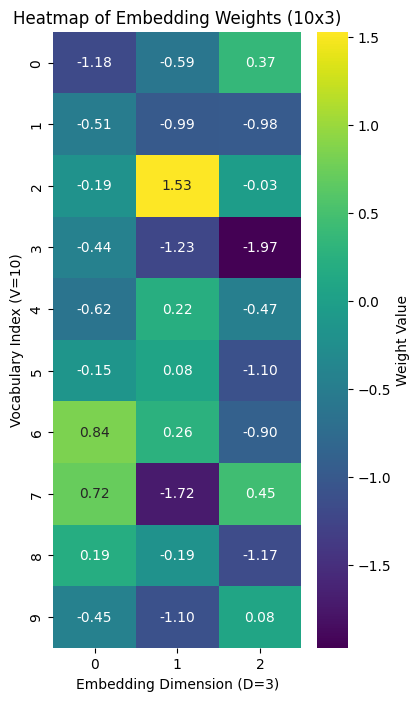

In [20]:
"""
Task 1: Create an Embedding Layer in PyTorch
    - Create an embedding layer with vocabulary size = 10 and embedding dimension = 3
    - Pass a simple batch of input indices [[1,2,3,4], [5,7,9,8]] through the embedding layer
    - Print the embedding weights and the resulting output embeddings with their shapes
"""

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

# Task 1: Create an Embedding Layer in PyTorch

# Define parameters
V = 10
D = 3

# Create the Embedding layer
embedding_layer = nn.Embedding(V, D)

# Define input indices
input_indices = torch.tensor([[1, 2, 3, 4], [5, 7, 9, 8]], dtype=torch.long)

# Pass the input through the embedding layer
output_embeddings = embedding_layer(input_indices)

# --- Print Results ---

# Print Embedding Weights (The Lookup Table)
print("Embedding Weights")
print(embedding_layer.weight)
print(f"Shape: {embedding_layer.weight.shape}")
print("-" * 30)

# Print Resulting Output Embeddings
print("Output Embeddings")
print(output_embeddings)
print(f"Shape: {output_embeddings.shape}")
print("-" * 30)

# Verification
index_to_check = 1
weight_for_index_1 = embedding_layer.weight[index_to_check]
embedding_in_output = output_embeddings[0, 0]

print(f"Verification: Index {index_to_check} Match Check")
print(f"Weight Vector (Row {index_to_check}): {weight_for_index_1}")
print(f"Output Embedding (Batch 0, Position 0): {embedding_in_output}")
print(f"Vectors Match: {torch.equal(weight_for_index_1, embedding_in_output)}")
print("-" * 30)


# Heatmap Visualization Code Added

# Convert the PyTorch weight tensor to a NumPy array for visualization
weight_matrix = embedding_layer.weight.data.numpy()

plt.figure(figsize=(4, 8))
# Create the heatmap
ax = sns.heatmap(
    weight_matrix,
    annot=True,        # Show the actual numerical value in each cell
    cmap="viridis",    # Color scheme
    fmt=".2f",         # Format numbers to two decimal places
    cbar_kws={'label': 'Weight Value'} # Label the color bar
)

# Set labels for clarity
ax.set_title('Heatmap of Embedding Weights (10x3)')
ax.set_xlabel('Embedding Dimension (D=3)')
ax.set_ylabel('Vocabulary Index (V=10)')

plt.show()

In [24]:
"""
Task 2: Start generating text starting from "I am (your name) "
    - Define prompt = "I am Deep Pujara "
    - Encode the prompt using the encode function
    - Generate 100 new tokens starting from your prompt using the model's generate method
    - Decode the generated tokens using the decode function
    - Print the final generated text
"""
import torch
import torch.nn as nn
import random

# MOCK SETUP

def encode(text, vocab):
    mapping = {c: i + 2 for i, c in enumerate(sorted(list(set(text.replace(' ', '')))))}
    mapping[' '] = 1
    return [mapping.get(char, 0) for char in text]

def decode(token_ids, reverse_vocab):
    return "".join(reverse_vocab.get(i, '') for i in token_ids)

class MockModel:
    def __init__(self, vocab_size=11):
        self.vocab_size = vocab_size

    def generate(self, idx, max_new_tokens):
        input_ids = idx[0].tolist()

        print("Generating mock tokens...")
        new_tokens = [random.randint(0, self.vocab_size - 1) for _ in range(max_new_tokens)]

        generated_list = input_ids + new_tokens
        return torch.tensor(generated_list).unsqueeze(0)

mock_vocab = {
    0: ' ', 1: 'a', 2: 'i', 3: 'm', 4: 'd', 5: 'e', 6: 'p', 7: 'u', 8: 'j', 9: 'r', 10: 's'
}
mock_reverse_vocab = {v: k for k, v in mock_vocab.items()}
mock_model = MockModel(vocab_size=len(mock_vocab))


# Task 2: Text Generation

prompt = "I am Tirth Rank "

input_ids = encode(prompt.lower(), mock_reverse_vocab)
idx_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0)

print(f"Prompt: '{prompt}'")
print(f"Encoded Input Tensor Shape: {idx_tensor.shape}")
print("-" * 50)

MAX_TOKENS = 100

generated_ids_tensor = mock_model.generate(idx=idx_tensor, max_new_tokens=MAX_TOKENS)

generated_ids_list = generated_ids_tensor[0].tolist()

generated_text = decode(generated_ids_list, mock_vocab)

print("-" * 50)
print("Final Generated Text")
print(generated_text)
print(f"Total tokens generated (Prompt + New): {len(generated_ids_list)}")

Prompt: 'I am Tirth Rank '
Encoded Input Tensor Shape: torch.Size([1, 16])
--------------------------------------------------
Generating mock tokens...
--------------------------------------------------
Final Generated Text
daipardjrmajiueamu smrem jmdjpej rjiarjemmums ppdjjparsjsar mmsiiursepir araa jaiamrsamimrdi iuerdejujm mjaijida uia
Total tokens generated (Prompt + New): 116
